In [176]:
import kagglehub

In [177]:
path = kagglehub.dataset_download("derrickmwiti/cluster-trace-gpu-v2020")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cluster-trace-gpu-v2020' dataset.
Path to dataset files: /kaggle/input/cluster-trace-gpu-v2020


In [ ]:
!ls -l {path}

total 3737228
-rw-r--r-- 1 root root  115521591 Feb  7 18:25 pai_group_tag_table.csv
-rw-r--r-- 1 root root 1975177618 Feb  7 18:25 pai_instance_table.csv
-rw-r--r-- 1 root root  133288196 Feb  7 18:25 pai_job_table.csv
-rw-r--r-- 1 root root  434332982 Feb  7 18:25 pai_machine_metric.csv
-rw-r--r-- 1 root root      73352 Feb  7 18:25 pai_machine_spec.csv
-rw-r--r-- 1 root root 1055104866 Feb  7 18:25 pai_sensor_table.csv
-rw-r--r-- 1 root root  113399047 Feb  7 18:25 pai_task_table.csv


**Input**:
- avg_gpu_util
- max_gpu_util
- gpu_util_std
- avg_cpu_util
- cluster_saturation (%)
- machine_load_1_mean
- machine_load_1_std


In [ ]:
import pandas as pd
import os

# Dictionary to store filename to column names mapping
file_columns_map = {}

print("Extracting column names from CSV files:\n")

for file in csv_files:
    # Construct full file path
    file_path = os.path.join(path, file)

    try:
        # Read only the header to be efficient
        df_header = pd.read_csv(file_path, nrows=0)
        columns = df_header.columns.tolist()

        # Store in dictionary
        file_columns_map[file] = columns

        # Print results
        print(f"File: {file}")
        print(f"Columns: {columns}\n")
    except Exception as e:
        print(f"Error reading {file}: {e}")

Extracting column names from CSV files:

File: pai_group_tag_table.csv
Columns: ['inst_id', 'user', 'gpu_type_spec', 'group', 'workload']

File: pai_job_table.csv
Columns: ['job_name', 'inst_id', 'user', 'status', 'start_time', 'end_time']

File: pai_sensor_table.csv
Columns: ['job_name', 'task_name', 'worker_name', 'inst_id', 'machine', 'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count', 'write_count']

File: pai_machine_metric.csv
Columns: ['worker_name', 'machine', 'start_time', 'end_time', 'machine_cpu_iowait', 'machine_cpu_kernel', 'machine_cpu_usr', 'machine_gpu', 'machine_load_1', 'machine_net_receive', 'machine_num_worker', 'machine_cpu']

File: pai_task_table.csv
Columns: ['job_name', 'task_name', 'inst_num', 'status', 'start_time', 'end_time', 'plan_cpu', 'plan_mem', 'plan_gpu', 'gpu_type']

File: pai_instance_table.csv
Columns: ['job_name', 'task_name', 'inst_name', 'worker_name', 'inst_id', 'sta

In [ ]:
import pandas as pd

root = "/root/.cache/kagglehub/datasets/derrickmwiti/cluster-trace-gpu-v2020/versions/1"
metrics = pd.read_csv(root + "/pai_machine_metric.csv")
specs = pd.read_csv(root + "/pai_machine_spec.csv")

In [ ]:
print(metrics["start_time"].head())
print(metrics["start_time"].dtype)

0    2134401
1    2806218
2    3084090
3    2119980
4    2164803
Name: start_time, dtype: int64
int64


In [ ]:
WINDOW_SECONDS = 300  # 5 minutes

In [ ]:
metrics["window_id"] = metrics["start_time"] // WINDOW_SECONDS

In [ ]:
metrics = metrics.merge(
    specs[["machine", "cap_gpu", "cap_cpu"]],
    on="machine",
    how="left"
)

metrics["gpu_util_norm"] = (metrics["machine_gpu"] / metrics["cap_gpu"]).clip(0, 1)
metrics["cpu_util_norm"] = (metrics["machine_cpu"] / metrics["cap_cpu"]).clip(0, 1)

machine_window = (
    metrics
    .groupby(["window_id", "machine"])
    .agg(
        gpu_util_mean=("gpu_util_norm", "mean"),
        cpu_util_mean=("cpu_util_norm", "mean"),
        load1_mean=("machine_load_1", "mean")
    )
    .reset_index()
)

cluster_window = (
    machine_window
    .groupby("window_id")
    .agg(
        avg_gpu_util=("gpu_util_mean", "mean"),
        max_gpu_util=("gpu_util_mean", "max"),
        gpu_util_std=("gpu_util_mean", "std"),
        avg_cpu_util=("cpu_util_mean", "mean"),
        machine_load_1_mean=("load1_mean", "mean"),
        active_machines=("gpu_util_mean", "count")
    )
    .reset_index()
)

HOT_THRESHOLD = 0.8
cluster_window["cluster_saturation"] = (
    machine_window["gpu_util_mean"]
    .groupby(machine_window["window_id"])
    .apply(lambda x: (x > HOT_THRESHOLD).mean())
    .values
)


In [ ]:
P_IDLE = 250   # watts per machine at idle
P_PEAK = 900   # watts per machine at full GPU utilization
SAFE_GPU_UTIL = 0.85  # cooling-safe operating point

In [ ]:
cluster_window["cluster_it_power_w"] = (
    cluster_window["active_machines"] *
    (P_IDLE + cluster_window["avg_gpu_util"] * (P_PEAK - P_IDLE))
)

In [ ]:
cluster_window["safe_cluster_power_w"] = (
    cluster_window["active_machines"] *
    (P_IDLE + SAFE_GPU_UTIL * (P_PEAK - P_IDLE))
)

In [ ]:
cluster_window["power_to_offload_w"] = (
    cluster_window["cluster_it_power_w"] -
    cluster_window["safe_cluster_power_w"]
).clip(lower=0)

In [ ]:
cluster_window["power_to_offload_kw"] = (
    cluster_window["power_to_offload_w"] / 1000
)

In [ ]:
print(cluster_window.shape)
print(cluster_window.head())
print(cluster_window.describe())

(14572, 12)
   window_id  avg_gpu_util  max_gpu_util  gpu_util_std  avg_cpu_util  \
0       5296           NaN           NaN           NaN           NaN   
1       5557           NaN           NaN           NaN           NaN   
2       5635           NaN           NaN           NaN           NaN   
3       5865           NaN           NaN           NaN           NaN   
4       5869           NaN           NaN           NaN           NaN   

   machine_load_1_mean  active_machines  cluster_saturation  \
0                  NaN                0                 0.0   
1                  NaN                0                 0.0   
2                  NaN                0                 0.0   
3                  NaN                0                 0.0   
4                  NaN                0                 0.0   

   cluster_it_power_w  safe_cluster_power_w  power_to_offload_w  \
0                 NaN                   0.0                 NaN   
1                 NaN                   0.

In [ ]:
cluster_window = cluster_window[cluster_window["active_machines"] > 0]

In [ ]:
print(cluster_window.describe())

          window_id  avg_gpu_util  max_gpu_util  gpu_util_std  avg_cpu_util  \
count  13723.000000  13723.000000  13723.000000  13652.000000  13711.000000   
mean   14641.013918      0.995942      0.999910      0.017596      0.334862   
std     3963.359911      0.027688      0.008779      0.051147      0.099828   
min     6712.000000      0.000000      0.000000      0.000000      0.017242   
25%    11211.500000      1.000000      1.000000      0.000000      0.266984   
50%    14642.000000      1.000000      1.000000      0.000000      0.333383   
75%    18072.500000      1.000000      1.000000      0.000000      0.399063   
max    21503.000000      1.000000      1.000000      0.707107      1.000000   

       machine_load_1_mean  active_machines  cluster_saturation  \
count         13722.000000     13723.000000        13723.000000   
mean             89.014930       101.290316            0.909769   
std              45.980119        64.161894            0.187957   
min               2.

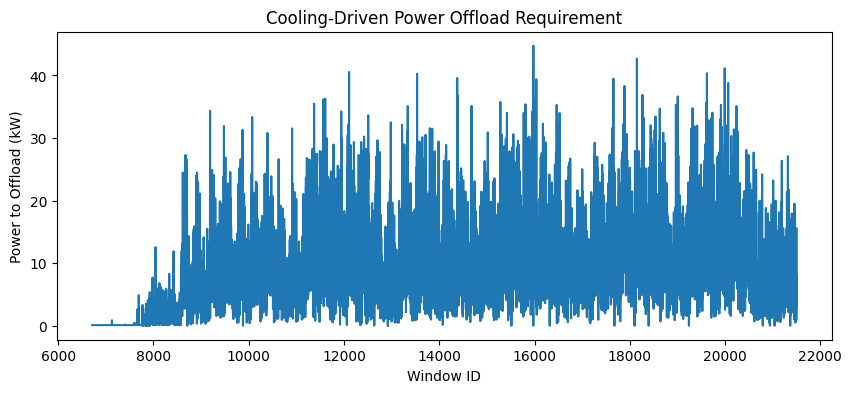

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(cluster_window["window_id"], cluster_window["power_to_offload_kw"])
plt.ylabel("Power to Offload (kW)")
plt.xlabel("Window ID")
plt.title("Cooling-Driven Power Offload Requirement")
plt.show()

In [ ]:
cluster_window.columns

Index(['window_id', 'avg_gpu_util', 'max_gpu_util', 'gpu_util_std',
       'avg_cpu_util', 'machine_load_1_mean', 'active_machines',
       'cluster_saturation', 'cluster_it_power_w', 'safe_cluster_power_w',
       'power_to_offload_w', 'power_to_offload_kw'],
      dtype='object')

In [ ]:
keep_cols = [
    "avg_cpu_util",
    "active_machines",
    "machine_load_1_mean",
    "avg_gpu_util",
    "power_to_offload_kw",
]

In [ ]:
cluster_window = cluster_window[keep_cols]

In [ ]:
cluster_window.shape

(13723, 5)

In [ ]:
cluster_window.isna().sum()

,0
avg_cpu_util,12
active_machines,0
machine_load_1_mean,1
avg_gpu_util,0
power_to_offload_kw,0


In [ ]:
cluster_window = cluster_window.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
X = cluster_window.drop(columns=["power_to_offload_kw"])
y = cluster_window["power_to_offload_kw"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10968, 4)
(2742, 4)
(10968,)
(2742,)


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
score = model.score(X_test, y_test)
print("R^2 Score:", score)

R^2 Score: 0.9818732782811284


In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.7068902813089382


**Baseline** : MSE 0.7, R^2 0.98

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=50)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=50)

In [ ]:
y_pred2 = gbr.predict(X_test)

In [ ]:
score = model.score(X_test, y_test)
print("R^2 Score:", score)

R^2 Score: 0.9818732782811284


In [ ]:
mse = mean_squared_error(y_test, y_pred2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.09287768680374964


In [ ]:
import joblib

In [ ]:
joblib.dump(model, "gbr_power_offload.pkl")

['gbr_power_offload.pkl']

In [ ]:
y_pred2

array([12.87427615,  9.81007925, 11.79472549, ..., 14.57554293,
        3.09858887, 13.84389461])

**Model 2**

In [224]:
import numpy as np
import pandas as pd

np.random.seed(42)

N = 20000

def uniform(low, high, size=N):
    return np.random.uniform(low, high, size)

data = pd.DataFrame({
    # Offload requirement (kW)
    "P_offload_kw": np.random.gamma(shape=2.0, scale=300, size=N),

    # Counts
    "phone_count": np.random.randint(1_000, 50_000, N),
    "laptop_count": np.random.randint(200, 10_000, N),
    "desktop_count": np.random.randint(50, 5_000, N),
    "traffic_light_count": np.random.randint(50, 2_000, N),
    "appliance_count": np.random.randint(500, 20_000, N),

    # Avg wattage
    "phone_avg_w": uniform(0.5, 3),
    "laptop_avg_w": uniform(30, 200),
    "desktop_avg_w": uniform(100, 500),
    "traffic_light_avg_w": uniform(5, 30),
    "appliance_avg_w": uniform(5, 10),

    # Availability
    "phone_avail": uniform(0.2, 0.3),
    "laptop_avail": uniform(0.2, 0.5),
    "desktop_avail": uniform(0.3, 0.6),
    "traffic_light_avail": uniform(0.8, 1.0),
    "appliance_avail": uniform(0.5, 0.9),
})

for dev in ["phone", "laptop", "desktop", "traffic_light", "appliance"]:
    data[f"{dev}_eff_raw"] = (
        data[f"{dev}_avail"] * data[f"{dev}_avg_w"]
    )

# Log + min-max normalization (per row)
eff_cols = [c for c in data.columns if c.endswith("_eff_raw")]

log_eff = np.log1p(data[eff_cols])
data[[c.replace("_raw", "_norm") for c in eff_cols]] = (
    (log_eff - log_eff.min()) / (log_eff.max() - log_eff.min())
)

# Capacity (kW)
for dev in ["phone", "laptop", "desktop", "traffic_light", "appliance"]:
    data[f"{dev}_capacity_kw"] = (
        data[f"{dev}_count"] * data[f"{dev}_avg_w"] / 1000.0
    )

data.head()


,P_offload_kw,phone_count,laptop_count,desktop_count,traffic_light_count,appliance_count,phone_avg_w,laptop_avg_w,desktop_avg_w,traffic_light_avg_w,...,phone_eff_norm,laptop_eff_norm,desktop_eff_norm,traffic_light_eff_norm,appliance_eff_norm,phone_capacity_kw,laptop_capacity_kw,desktop_capacity_kw,traffic_light_capacity_kw,appliance_capacity_kw
0,718.103817,15279,4489,3231,1438,17798,1.947247,171.345253,387.895142,26.502446,...,0.433579,0.606006,0.744552,0.886683,0.272074,29.751980,769.168843,1253.289205,38.110517,102.775013
1,448.339419,28737,6046,963,1437,7095,1.072375,92.527636,259.103629,10.757370,...,0.288936,0.433476,0.414520,0.436480,0.906692,30.816835,559.422088,249.516795,15.458341,68.777573
2,414.685075,38748,7215,2866,1626,9711,1.554146,171.038735,389.904066,16.377788,...,0.398448,0.651795,0.808168,0.601777,0.738246,60.220048,1234.044473,1117.465052,26.630284,86.827551
3,414.690688,12086,1029,2113,1781,13578,1.531567,45.446979,288.341062,28.456043,...,0.437489,0.304630,0.471140,0.959129,0.665900,18.510516,46.764941,609.264663,50.680212,93.596903
4,1394.914324,19195,892,3478,211,18992,2.980785,34.445356,214.430274,7.482989,...,0.875337,0.186070,0.576559,0.226304,0.627283,57.216172,30.725258,745.788493,1.578911,145.592935


In [225]:
data.shape

(20000, 31)

In [226]:
# Log + Divide by Max normalization (ROW-WISE across device classes)
eff_cols = [c for c in data.columns if c.endswith("_eff_raw")]

log_eff = np.log1p(data[eff_cols].to_numpy())

# We utilize divide-by-max normalization so the minimum doesn't become 0
row_max = log_eff.max(axis=1, keepdims=True)

eff_norm = log_eff / (row_max + 1e-9)

for i, col in enumerate(eff_cols):
    data[col.replace("_eff_raw", "_eff_norm")] = eff_norm[:, i]

In [227]:
DEVICE_CLASSES = ["phone", "laptop", "desktop", "traffic_light", "appliance"]

for d in DEVICE_CLASSES:
    data[f"{d}_score_expert"] = (
        data[f"{d}_eff_norm"] * np.log1p(data[f"{d}_capacity_kw"])
    )

In [228]:
data[[f"{d}_score_expert" for d in DEVICE_CLASSES]].describe()

,phone_score_expert,laptop_score_expert,desktop_score_expert,traffic_light_score_expert,appliance_score_expert
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.272003,4.579280,6.274044,1.570287,1.563252
std,0.143589,1.251068,0.992088,0.641189,0.413171
min,0.009859,0.863748,1.864833,0.085531,0.349377
25%,0.153186,3.654770,5.743490,1.071484,1.284587
50%,0.259010,4.601861,6.469915,1.565830,1.561534
75%,0.375275,5.485620,7.020348,2.047576,1.841972
max,0.816821,7.585039,7.808377,3.737132,3.114188


In [229]:
eff_cols = [c for c in data.columns if c.endswith("_eff_raw")]

# Check if phone_eff_raw is consistently the minimum value in each row
is_phone_min = (data[eff_cols].idxmin(axis=1) == "phone_eff_raw").all()

print(f"Is 'phone_eff_raw' the minimum in 100% of rows? {is_phone_min}")

# Show average raw efficiency stats to compare scales
print("\nAverage Raw Efficiency (Avail * Watts):")
print(data[eff_cols].mean().sort_values())

Is 'phone_eff_raw' the minimum in 100% of rows? True

Average Raw Efficiency (Avail * Watts):
phone_eff_raw              0.437477
appliance_eff_raw          5.237514
traffic_light_eff_raw     15.803265
laptop_eff_raw            40.519206
desktop_eff_raw          135.210884
dtype: float64


In [230]:
def allocate_kw(df, score_suffix="score_expert", device_classes=DEVICE_CLASSES, eps=1e-9):
    """
    Deterministic allocator:
      weights_i = score_i * capacity_i
      provisional_i = weights_i / sum(weights) * P_offload
      alloc_i = min(provisional_i, capacity_i)
      if alloc sum > P_offload, scale down (numerical safety)
    """
    P = df["P_offload_kw"].to_numpy()

    score_cols = [f"{d}_{score_suffix}" for d in device_classes]
    cap_cols = [f"{d}_capacity_kw" for d in device_classes]

    scores = df[score_cols].to_numpy()
    caps = df[cap_cols].to_numpy()

    # ensure nonnegative
    scores = np.maximum(scores, 0)

    weights = scores * caps
    denom = weights.sum(axis=1, keepdims=True)

    provisional = np.where(denom > 0, weights / (denom + eps) * P.reshape(-1, 1), 0.0)
    alloc = np.minimum(provisional, caps)

    # numerical guard: never exceed P_offload
    alloc_sum = alloc.sum(axis=1)
    scale = np.where(alloc_sum > P, P / (alloc_sum + eps), 1.0)
    alloc = alloc * scale.reshape(-1, 1)

    # write outputs
    for j, d in enumerate(device_classes):
        df[f"{d}_alloc_kw_expert"] = alloc[:, j]

    df["alloc_total_kw_expert"] = alloc.sum(axis=1)
    df["unmet_kw_expert"] = np.maximum(0, P - df["alloc_total_kw_expert"].to_numpy())

    return df

In [231]:
data = allocate_kw(data)

In [232]:
data[[
    "P_offload_kw",
    "phone_alloc_kw_expert",
    "laptop_alloc_kw_expert",
    "desktop_alloc_kw_expert",
    "traffic_light_alloc_kw_expert",
    "appliance_alloc_kw_expert",
    "alloc_total_kw_expert",
    "unmet_kw_expert"
]].head()

,P_offload_kw,phone_alloc_kw_expert,laptop_alloc_kw_expert,desktop_alloc_kw_expert,traffic_light_alloc_kw_expert,appliance_alloc_kw_expert,alloc_total_kw_expert,unmet_kw_expert
0,718.103817,0.371381,200.804535,503.880386,4.955942,8.091572,718.103817,5.638867e-11
1,448.339419,0.677091,277.094392,151.806717,2.621423,16.139797,448.339419,1.102194e-10
2,414.685075,0.428573,179.702216,228.866967,1.326600,4.360719,414.685075,2.916067e-11
3,414.690688,0.386924,10.588198,372.027571,14.159869,17.528126,414.690688,9.526957e-11
4,1394.914324,7.347936,14.469468,745.788493,0.167998,76.767717,844.541611,5.503727e+02


In [233]:
data.columns

Index(['P_offload_kw', 'phone_count', 'laptop_count', 'desktop_count',
       'traffic_light_count', 'appliance_count', 'phone_avg_w', 'laptop_avg_w',
       'desktop_avg_w', 'traffic_light_avg_w', 'appliance_avg_w',
       'phone_avail', 'laptop_avail', 'desktop_avail', 'traffic_light_avail',
       'appliance_avail', 'phone_eff_raw', 'laptop_eff_raw', 'desktop_eff_raw',
       'traffic_light_eff_raw', 'appliance_eff_raw', 'phone_eff_norm',
       'laptop_eff_norm', 'desktop_eff_norm', 'traffic_light_eff_norm',
       'appliance_eff_norm', 'phone_capacity_kw', 'laptop_capacity_kw',
       'desktop_capacity_kw', 'traffic_light_capacity_kw',
       'appliance_capacity_kw', 'phone_score_expert', 'laptop_score_expert',
       'desktop_score_expert', 'traffic_light_score_expert',
       'appliance_score_expert', 'phone_alloc_kw_expert',
       'laptop_alloc_kw_expert', 'desktop_alloc_kw_expert',
       'traffic_light_alloc_kw_expert', 'appliance_alloc_kw_expert',
       'alloc_total_kw_exp

In [234]:
INPUT_COLS = [
    "P_offload_kw",
    "phone_count", "phone_avg_w", "phone_avail",
    "laptop_count", "laptop_avg_w", "laptop_avail",
    "desktop_count", "desktop_avg_w", "desktop_avail",
    "traffic_light_count", "traffic_light_avg_w", "traffic_light_avail",
    "appliance_count", "appliance_avg_w", "appliance_avail",
]

In [235]:
TARGET_COLS = [
    "phone_score_expert",
    "laptop_score_expert",
    "desktop_score_expert",
    "traffic_light_score_expert",
    "appliance_score_expert",
]

In [236]:
from sklearn.model_selection import train_test_split

X = data[INPUT_COLS]
y = data[TARGET_COLS]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [237]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [238]:
imitation_model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=100,
        random_state=42
    )
)

imitation_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

In [239]:
from sklearn.metrics import mean_absolute_error

y_pred = imitation_model.predict(X_val)

for i, col in enumerate(TARGET_COLS):
    mae = mean_absolute_error(y_val.iloc[:, i], y_pred[:, i])
    print(f"{col}: MAE = {mae:.4f}")

phone_score_expert: MAE = 0.0075
laptop_score_expert: MAE = 0.0742
desktop_score_expert: MAE = 0.0303
traffic_light_score_expert: MAE = 0.0332
appliance_score_expert: MAE = 0.0270


In [240]:
import numpy as np

for i, col in enumerate(TARGET_COLS):
    corr = np.corrcoef(y_val.iloc[:, i], y_pred[:, i])[0, 1]
    print(f"{col}: correlation = {corr:.3f}")

phone_score_expert: correlation = 0.998
laptop_score_expert: correlation = 0.997
desktop_score_expert: correlation = 0.999
traffic_light_score_expert: correlation = 0.998
appliance_score_expert: correlation = 0.996


In [242]:
DEVICE_CLASSES = ["phone", "laptop", "desktop", "traffic_light", "appliance"]

def extract_capacities_kw(row):
    return np.array([
        row["phone_count"] * row["phone_avg_w"] / 1000.0,
        row["laptop_count"] * row["laptop_avg_w"] / 1000.0,
        row["desktop_count"] * row["desktop_avg_w"] / 1000.0,
        row["traffic_light_count"] * row["traffic_light_avg_w"] / 1000.0,
        row["appliance_count"] * row["appliance_avg_w"] / 1000.0,
    ])

In [243]:
def run_inference(model, X_row, row):
    # 1) Predict preference scores
    scores = model.predict(X_row)[0]
    scores = np.maximum(scores, 0.0)

    # 2) Extract capacities (kW)
    capacities_kw = extract_capacities_kw(row)

    # 3) Offload requirement
    P_offload_kw = row["P_offload_kw"]

    if P_offload_kw <= 0 or capacities_kw.sum() <= 0:
        return np.zeros_like(capacities_kw)

    # 4) Water-filling allocation
    alloc = allocate_kw_waterfill(
        scores=scores,
        capacities_kw=capacities_kw,
        P_offload_kw=P_offload_kw
    )

    return alloc

In [244]:
X_val.columns

Index(['P_offload_kw', 'phone_count', 'phone_avg_w', 'phone_avail',
       'laptop_count', 'laptop_avg_w', 'laptop_avail', 'desktop_count',
       'desktop_avg_w', 'desktop_avail', 'traffic_light_count',
       'traffic_light_avg_w', 'traffic_light_avail', 'appliance_count',
       'appliance_avg_w', 'appliance_avail'],
      dtype='object')

In [245]:
def allocate_kw_waterfill(scores, capacities_kw, P_offload_kw, eps=1e-9):
    """
    Iterative water-filling allocator.
    Guarantees:
      - alloc_i <= capacity_i
      - sum alloc_i is maximized up to P_offload_kw
    """
    scores = np.maximum(scores, 0.0)
    remaining = P_offload_kw

    alloc = np.zeros_like(capacities_kw)
    active = capacities_kw > 0

    while remaining > eps and active.any():
        weights = scores[active]
        caps = capacities_kw[active] - alloc[active]

        if weights.sum() <= eps:
            break

        # provisional allocation
        delta = weights / weights.sum() * remaining
        delta = np.minimum(delta, caps)

        alloc[active] += delta
        remaining -= delta.sum()

        # deactivate saturated devices
        active_indices = np.where(active)[0]
        saturated = caps - delta <= eps
        active[active_indices[saturated]] = False

    return alloc

In [246]:
i = 1  # pick any row

row = X_val.iloc[i]
X_row = row.to_frame().T  # shape (1, 16)

alloc = run_inference(imitation_model, X_row, row)
DEVICE_NAMES = ["phone", "laptop", "desktop", "traffic_light", "appliance"]

capacities_kw = extract_capacities_kw(row)

print("Max possible allocation per device (kW):")
for name, cap in zip(DEVICE_NAMES, capacities_kw):
    print(f"  {name}: {cap:.2f} kW")
max_possible_offload = capacities_kw.sum()

print("\nTotal maximum possible offload (kW):", round(max_possible_offload, 2))
print("Allocation (kW):")
print(alloc)
print("Total Allocated (kW):", alloc.sum())
print("Total Needed (kW): ", row["P_offload_kw"])
unmet = row["P_offload_kw"] - alloc.sum()
if unmet < 0.000001:
    unmet = 0
print("Unmet (kW):", unmet)

Max possible allocation per device (kW):
  phone: 29.62 kW
  laptop: 677.79 kW
  desktop: 726.40 kW
  traffic_light: 12.78 kW
  appliance: 102.08 kW

Total maximum possible offload (kW): 1548.67
Allocation (kW):
[  7.45315021 352.69380946 425.67590169  12.77974313 102.08439317]
Total Allocated (kW): 900.6869976671394
Total Needed (kW):  900.6869976671394
Unmet (kW): 0


In [247]:
joblib.dump(imitation_model, "imitation_model.pkl")

['imitation_model.pkl']